In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

random_seed = 123
np.random.seed(random_seed)

In [63]:
! pip install pycaret

     |████████████████████████████████| 71kB 4.7MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


# 1. The data

Histone modifications play an important role in affecting gene regulation. Specific histone modifications at specific locations in or near the gene can alter the expression of genes. Predicting gene expression from histone modification signals is a widely studied research topic.

In this competition you will predict gene expression levels (low=0, high=1) based on the presence of histone modifications at specific locations in the gene. You will try to find the model that learns the true underlying model best.

For each gene a region of 10.000bp around the transcription start site of the gene is extracted (5000bp upstream and 5000bp downstream). This region is binned in 100 bins of 100bp. For each bin five core histone modification marks are counted [1].

The dataset is compiled from the "E047" (Primary T CD8+ naive cells from peripheral blood) celltype from Roadmap Epigenomics Mapping Consortium (REMC) database.

[1] Kundaje, A. et al. Integrative analysis of 111 reference human epige-
nomes. Nature, 518, 317–330, 2015.


We start by loading the Pandas library and reading the datasets into Pandas DataFrames:

In [64]:
import pandas as pd

train = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/ML-course-VIB-2020/master/data_train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/ML-course-VIB-2020/master/data_test.csv")

Let's look at a random sample of the trainset:

In [65]:
train.sample(20)

,GeneId,H3K4me3_0,H3K4me1_0,H3K36me3_0,H3K9me3_0,H3K27me3_0,H3K4me3_1,H3K4me1_1,H3K36me3_1,H3K9me3_1,H3K27me3_1,H3K4me3_2,H3K4me1_2,H3K36me3_2,H3K9me3_2,H3K27me3_2,H3K4me3_3,H3K4me1_3,H3K36me3_3,H3K9me3_3,H3K27me3_3,H3K4me3_4,H3K4me1_4,H3K36me3_4,H3K9me3_4,H3K27me3_4,H3K4me3_5,H3K4me1_5,H3K36me3_5,H3K9me3_5,H3K27me3_5,H3K4me3_6,H3K4me1_6,H3K36me3_6,H3K9me3_6,H3K27me3_6,H3K4me3_7,H3K4me1_7,H3K36me3_7,H3K9me3_7,...,H3K4me1_92,H3K36me3_92,H3K9me3_92,H3K27me3_92,H3K4me3_93,H3K4me1_93,H3K36me3_93,H3K9me3_93,H3K27me3_93,H3K4me3_94,H3K4me1_94,H3K36me3_94,H3K9me3_94,H3K27me3_94,H3K4me3_95,H3K4me1_95,H3K36me3_95,H3K9me3_95,H3K27me3_95,H3K4me3_96,H3K4me1_96,H3K36me3_96,H3K9me3_96,H3K27me3_96,H3K4me3_97,H3K4me1_97,H3K36me3_97,H3K9me3_97,H3K27me3_97,H3K4me3_98,H3K4me1_98,H3K36me3_98,H3K9me3_98,H3K27me3_98,H3K4me3_99,H3K4me1_99,H3K36me3_99,H3K9me3_99,H3K27me3_99,Label
9224,7775,0,1,0,0,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,4,2,0,2,2,7,2,1,3,1,4,1,1,4,...,2,1,1,2,0,1,0,0,1,0,0,2,1,0,0,1,3,1,1,1,1,1,1,2,0,0,0,0,1,0,0,0,0,0,0,0,1,2,0,1
6624,7005,0,2,2,0,1,0,4,2,1,0,1,3,1,2,1,1,10,1,2,0,1,1,2,0,0,1,3,1,0,1,1,2,0,1,2,1,4,3,0,...,1,0,0,0,2,5,0,0,3,0,5,0,0,0,0,4,0,1,0,1,1,0,1,0,1,1,1,2,1,0,0,1,2,2,1,0,0,1,2,0
7349,5082,0,0,0,1,1,0,0,2,0,1,0,1,0,0,1,0,2,1,0,1,0,2,2,2,0,0,0,2,2,2,1,1,0,0,2,1,1,0,3,...,3,7,1,0,0,0,5,0,0,0,2,1,1,0,0,2,8,0,0,0,1,8,0,0,0,0,4,2,1,1,0,9,1,3,0,1,6,0,4,1
1077,10976,1,0,0,2,0,2,1,0,0,1,5,0,3,3,1,8,2,1,2,2,5,0,0,2,1,7,0,0,3,1,5,1,2,2,0,4,1,3,2,...,1,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
758,4730,0,0,2,0,0,0,0,1,0,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,2,0,0,0,0,1,1,1,1,0,1,2,1,0,...,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,3,0,0,0,1,2,3,0,0,0,0,1,1,0,1,0,0,2,2,1,1,1,0
3591,79,4,1,1,0,2,2,1,1,1,2,1,0,1,2,1,0,1,1,3,1,1,4,2,5,1,1,4,1,0,2,3,2,1,2,2,2,0,0,2,...,1,0,0,1,1,1,1,1,2,0,1,2,1,0,3,3,2,0,0,2,2,2,2,1,4,4,4,4,3,2,1,3,1,2,0,1,2,0,0,0
8068,14868,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,2,1,2,0,2,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2106,7567,0,0,0,0,0,4,0,0,0,0,4,1,2,1,1,1,2,2,2,0,0,2,0,0,0,1,1,0,0,1,1,1,2,1,2,3,0,0,4,...,0,0,0,1,0,1,0,1,1,1,1,0,1,0,1,0,0,0,0,2,0,1,1,1,2,0,0,0,0,4,0,0,0,0,2,1,0,0,0,0
9300,2981,2,4,0,1,1,1,2,1,2,0,1,2,3,3,0,1,2,4,2,0,1,4,2,0,0,2,4,1,1,0,1,1,0,0,0,2,0,0,0,...,2,2,1,1,5,1,1,2,1,2,1,1,3,0,0,1,0,4,1,0,2,1,3,3,0,0,2,1,0,1,0,1,0,1,2,0,0,3,1,1
1138,11519,2,1,0,0,0,0,0,0,0,0,3,4,2,0,0,2,3,1,2,0,2,4,2,3,1,0,4,2,1,2,1,0,0,0,1,0,0,1,2,...,1,2,3,2,4,1,0,3,1,5,0,1,5,1,3,0,0,2,1,2,0,0,2,1,1,0,0,2,1,2,0,0,3,1,1,3,3,2,0,0


An alternative visualization for this type of counting data is the heatmap:

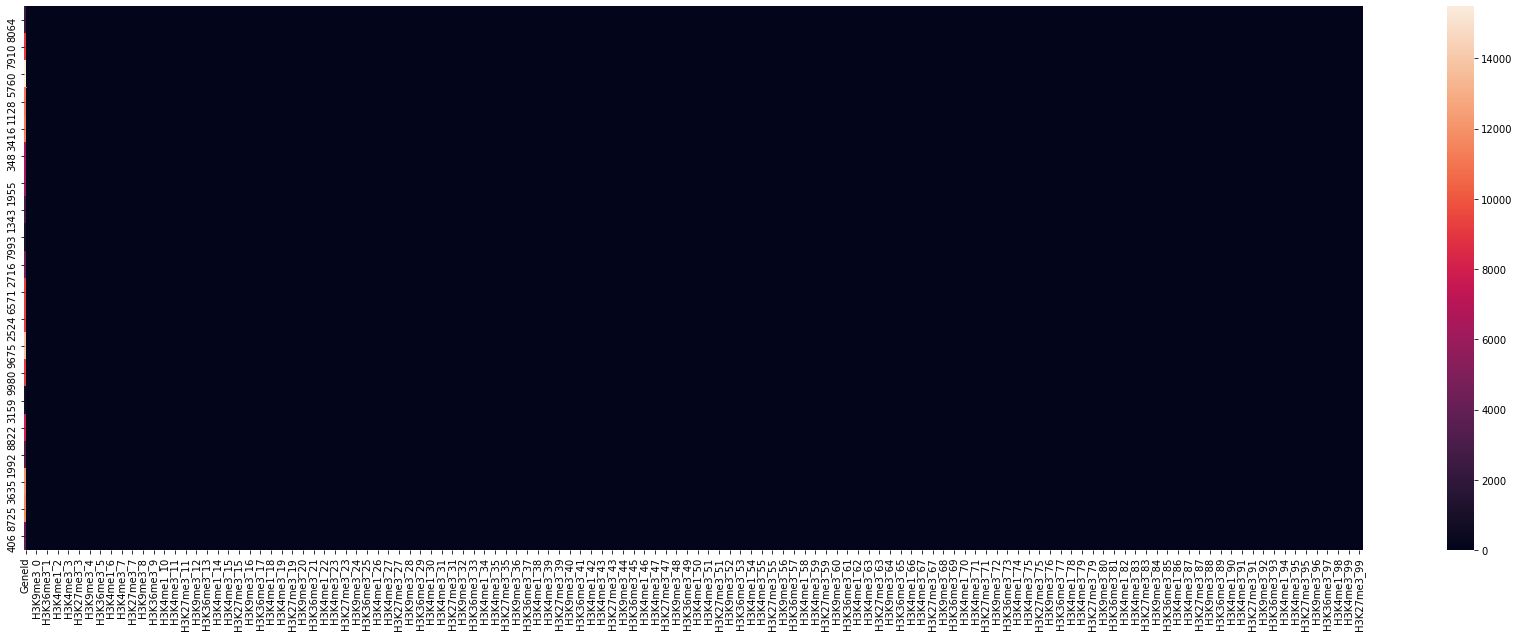

In [66]:
import seaborn as sns

plt.figure(figsize=(30,10))
sns.heatmap(train.sample(20))

Q: why is this not useful?

There is a column called `GeneId` that identifies the gene. This column should not be used as a feature. 

The label for each datapoint is in the `Label` column.

In [67]:
train_ids = train.pop("GeneId")
train_labels = train.pop("Label")

Now `train` contains the feature columns only.

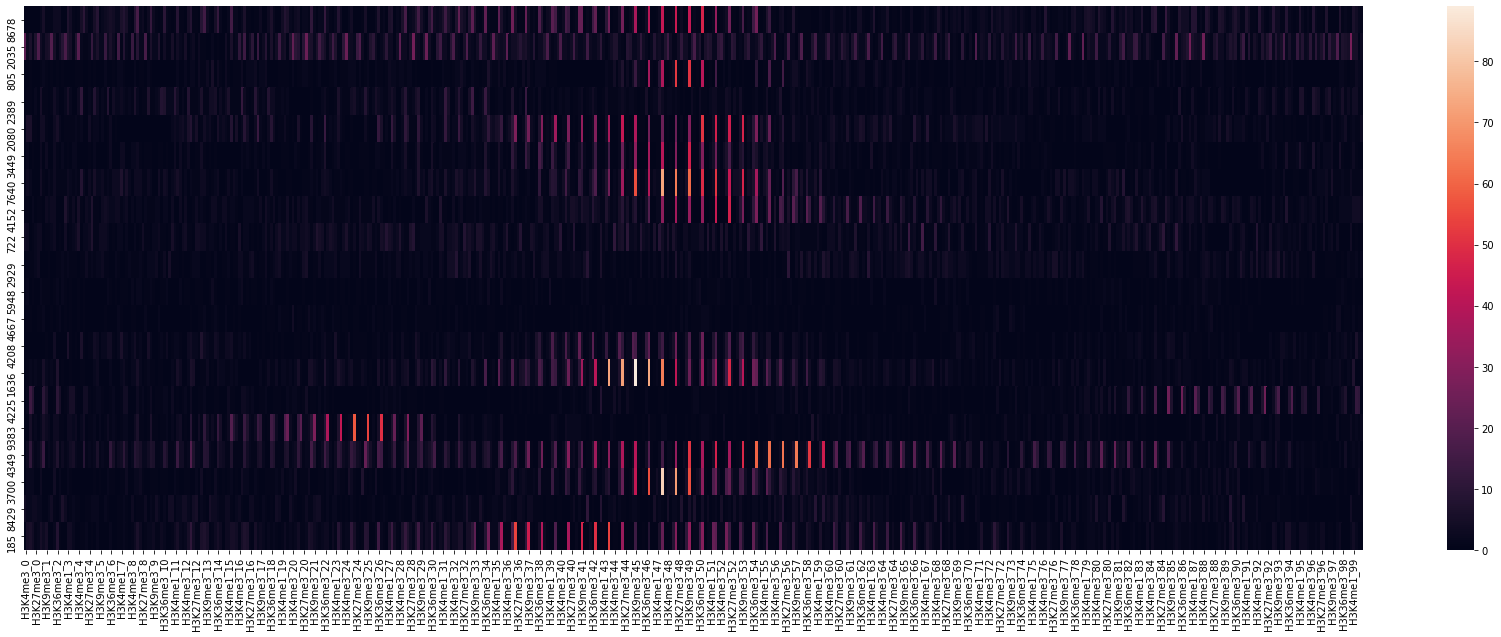

In [68]:
plt.figure(figsize=(30,10))
sns.heatmap(train.sample(20))

Let's look at the number datapoints in each class:

In [69]:
train_labels.value_counts()

1    5250
0    5186
Name: Label, dtype: int64

Let's look at `test`:

In [70]:
test.head(5)

,GeneId,H3K4me3_0,H3K4me1_0,H3K36me3_0,H3K9me3_0,H3K27me3_0,H3K4me3_1,H3K4me1_1,H3K36me3_1,H3K9me3_1,H3K27me3_1,H3K4me3_2,H3K4me1_2,H3K36me3_2,H3K9me3_2,H3K27me3_2,H3K4me3_3,H3K4me1_3,H3K36me3_3,H3K9me3_3,H3K27me3_3,H3K4me3_4,H3K4me1_4,H3K36me3_4,H3K9me3_4,H3K27me3_4,H3K4me3_5,H3K4me1_5,H3K36me3_5,H3K9me3_5,H3K27me3_5,H3K4me3_6,H3K4me1_6,H3K36me3_6,H3K9me3_6,H3K27me3_6,H3K4me3_7,H3K4me1_7,H3K36me3_7,H3K9me3_7,...,H3K4me3_92,H3K4me1_92,H3K36me3_92,H3K9me3_92,H3K27me3_92,H3K4me3_93,H3K4me1_93,H3K36me3_93,H3K9me3_93,H3K27me3_93,H3K4me3_94,H3K4me1_94,H3K36me3_94,H3K9me3_94,H3K27me3_94,H3K4me3_95,H3K4me1_95,H3K36me3_95,H3K9me3_95,H3K27me3_95,H3K4me3_96,H3K4me1_96,H3K36me3_96,H3K9me3_96,H3K27me3_96,H3K4me3_97,H3K4me1_97,H3K36me3_97,H3K9me3_97,H3K27me3_97,H3K4me3_98,H3K4me1_98,H3K36me3_98,H3K9me3_98,H3K27me3_98,H3K4me3_99,H3K4me1_99,H3K36me3_99,H3K9me3_99,H3K27me3_99
0,5222,2,2,7,2,0,3,2,9,2,0,1,7,8,1,0,0,2,5,4,0,0,2,5,2,0,2,4,10,3,0,0,4,10,1,0,1,2,6,2,...,1,1,2,0,3,3,1,1,0,1,2,2,0,2,1,3,1,0,2,1,2,0,1,0,1,0,0,0,1,0,0,2,1,1,0,0,3,1,1,1
1,891,1,2,0,0,1,0,4,1,2,4,1,2,2,3,4,1,1,2,3,1,2,2,3,1,1,1,0,0,0,0,0,0,0,0,1,2,0,0,0,...,0,3,0,2,3,0,1,1,3,0,1,0,1,1,3,1,0,0,0,1,1,0,0,0,0,3,3,0,1,0,3,2,2,2,0,4,2,5,2,1
2,7219,1,1,2,4,4,2,2,1,1,1,2,0,0,3,1,3,0,0,2,1,2,1,2,1,0,1,1,2,0,1,0,1,1,2,0,2,1,1,3,...,2,0,1,0,1,2,0,1,1,1,2,2,1,2,2,2,1,2,2,0,0,2,0,1,2,3,4,1,1,0,1,3,1,1,0,0,1,1,1,0
3,7225,1,5,2,4,1,0,8,3,4,0,0,3,2,2,0,0,0,1,0,0,2,0,1,2,1,2,2,2,2,2,1,5,0,0,0,1,4,2,2,...,2,7,0,4,2,0,2,0,4,1,0,2,1,2,1,0,3,0,3,0,1,0,0,2,2,0,1,0,0,4,0,2,1,1,2,1,1,0,2,0
4,9432,1,16,3,2,2,2,7,0,4,2,0,5,1,1,2,0,4,1,0,2,0,4,1,1,2,0,3,2,2,2,0,1,2,1,3,1,5,2,0,...,1,0,1,1,0,3,1,2,1,1,2,0,3,3,0,4,2,3,2,1,4,2,2,1,3,3,0,0,0,3,0,1,2,0,1,1,1,1,2,1


This is a blind test so the `Label` column is not available in the testset. The testset does contain the `GeneId` column that is needed to send your predictions to the Kaggle website.


In [71]:
test_index_col = test.pop("GeneId")

We can get some general statistics about the trainset using the DataFrame `.describe()` function:

In [72]:
train.describe()

,H3K4me3_0,H3K4me1_0,H3K36me3_0,H3K9me3_0,H3K27me3_0,H3K4me3_1,H3K4me1_1,H3K36me3_1,H3K9me3_1,H3K27me3_1,H3K4me3_2,H3K4me1_2,H3K36me3_2,H3K9me3_2,H3K27me3_2,H3K4me3_3,H3K4me1_3,H3K36me3_3,H3K9me3_3,H3K27me3_3,H3K4me3_4,H3K4me1_4,H3K36me3_4,H3K9me3_4,H3K27me3_4,H3K4me3_5,H3K4me1_5,H3K36me3_5,H3K9me3_5,H3K27me3_5,H3K4me3_6,H3K4me1_6,H3K36me3_6,H3K9me3_6,H3K27me3_6,H3K4me3_7,H3K4me1_7,H3K36me3_7,H3K9me3_7,H3K27me3_7,...,H3K4me3_92,H3K4me1_92,H3K36me3_92,H3K9me3_92,H3K27me3_92,H3K4me3_93,H3K4me1_93,H3K36me3_93,H3K9me3_93,H3K27me3_93,H3K4me3_94,H3K4me1_94,H3K36me3_94,H3K9me3_94,H3K27me3_94,H3K4me3_95,H3K4me1_95,H3K36me3_95,H3K9me3_95,H3K27me3_95,H3K4me3_96,H3K4me1_96,H3K36me3_96,H3K9me3_96,H3K27me3_96,H3K4me3_97,H3K4me1_97,H3K36me3_97,H3K9me3_97,H3K27me3_97,H3K4me3_98,H3K4me1_98,H3K36me3_98,H3K9me3_98,H3K27me3_98,H3K4me3_99,H3K4me1_99,H3K36me3_99,H3K9me3_99,H3K27me3_99
count,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.00000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,...,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000,10436.000000
mean,1.482081,1.738885,2.342564,1.887792,1.134438,1.486393,1.738310,2.354159,1.906957,1.121694,1.479398,1.722116,2.363549,1.885684,1.137505,1.463971,1.726907,2.377923,1.893158,1.138271,1.471158,1.741663,2.400441,1.927846,1.121598,1.477578,1.708126,2.442986,1.920468,1.124952,1.503929,1.720966,2.462342,1.905232,1.13578,1.520123,1.681296,2.461575,1.921522,1.139613,...,1.488597,1.718570,2.509870,1.815447,1.099463,1.479494,1.721732,2.465025,1.797240,1.107512,1.463588,1.717133,2.473649,1.775201,1.115178,1.466175,1.740705,2.413664,1.776639,1.110100,1.457167,1.746359,2.429571,1.757857,1.119394,1.460234,1.759007,2.436182,1.748946,1.123131,1.458413,1.754120,2.437236,1.800882,1.141050,1.455922,1.738022,2.397183,1.826945,1.129935
std,1.883112,2.098565,3.798700,5.292531,1.455765,1.925768,2.094562,3.784454,5.334868,1.417511,1.877427,2.077745,3.781689,5.448426,1.420828,1.889508,2.109728,3.809019,5.403684,1.433245,1.879410,2.134382,3.842186,5.459619,1.427255,1.893214,2.053826,3.897871,5.360578,1.430956,1.900113,2.075560,3.897860,5.214749,1.40294,1.897235,2.015560,3.922654,5.145834,1.406044,...,1.846211,2.103376,3.964094,4.675360,1.375978,1.877275,2.083267,3.886855,4.592894,1.365022,1.836466,2.082509,3.955112,4.705680,1.377259,1.846092,2.125807,3.919961,4.710155,1.408323,1.799267,2.152224,3.902467,4.626802,1.385227,1.800774,2.146947,3.959504,4.483866,1.422415,1.840630,2.155949,3.950022,4.797043,1.455172,1.842602,2.134836,3.892699,4.924786,1.472372
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

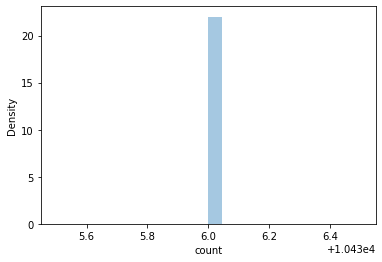

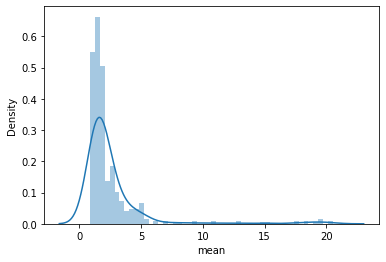

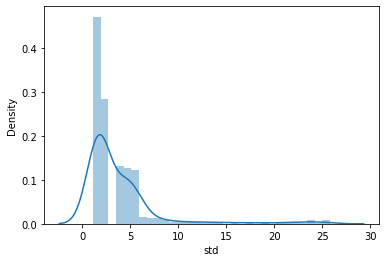

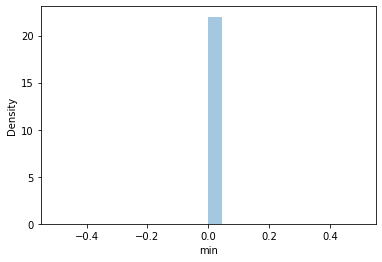

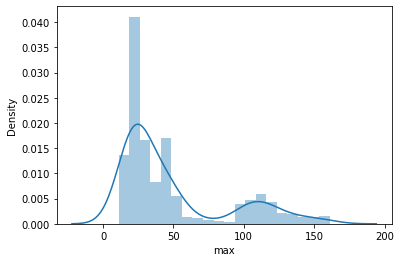

In [73]:
for col in ["count","mean","std","min","max"]:
  sns.distplot(pd.DataFrame(train.describe().transpose())[col])
  plt.show()

We can use the Pandas `boxplot()` function to plot the feature values:

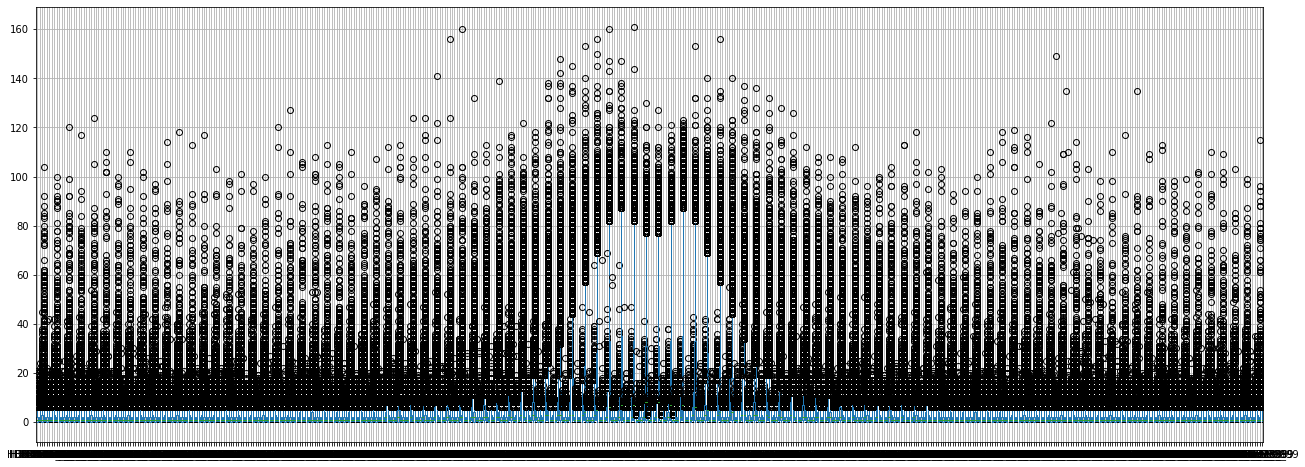

In [74]:
plt.figure(figsize=(22,8))
train.boxplot()
plt.show()

Let's plot these for each hisotone mark:

In [75]:
marks = {}
for m in train.columns:
  marks[m.split("_")[0]] = True
marks = list(marks.keys())
marks

['H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'H3K27me3']

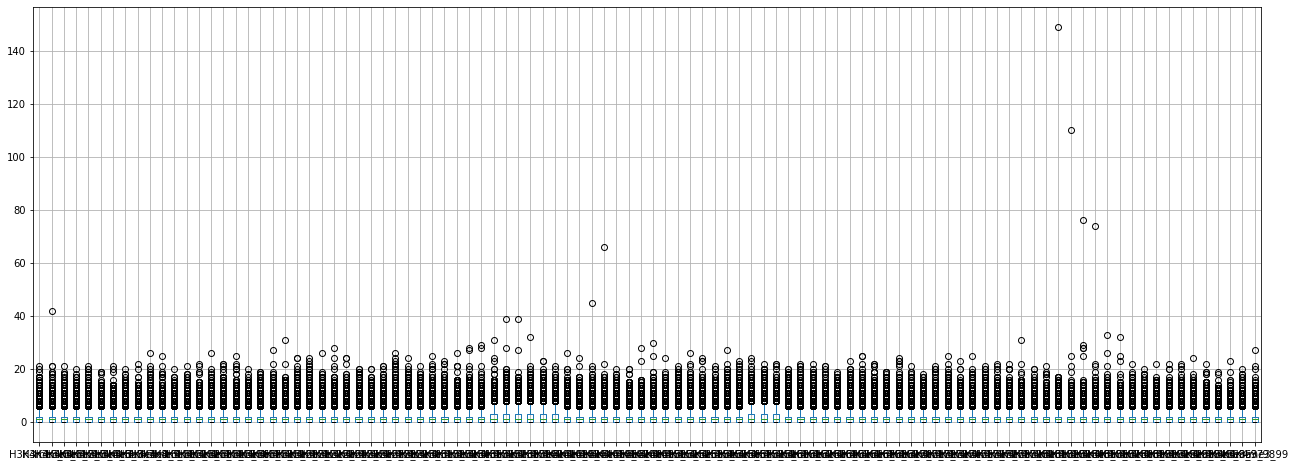

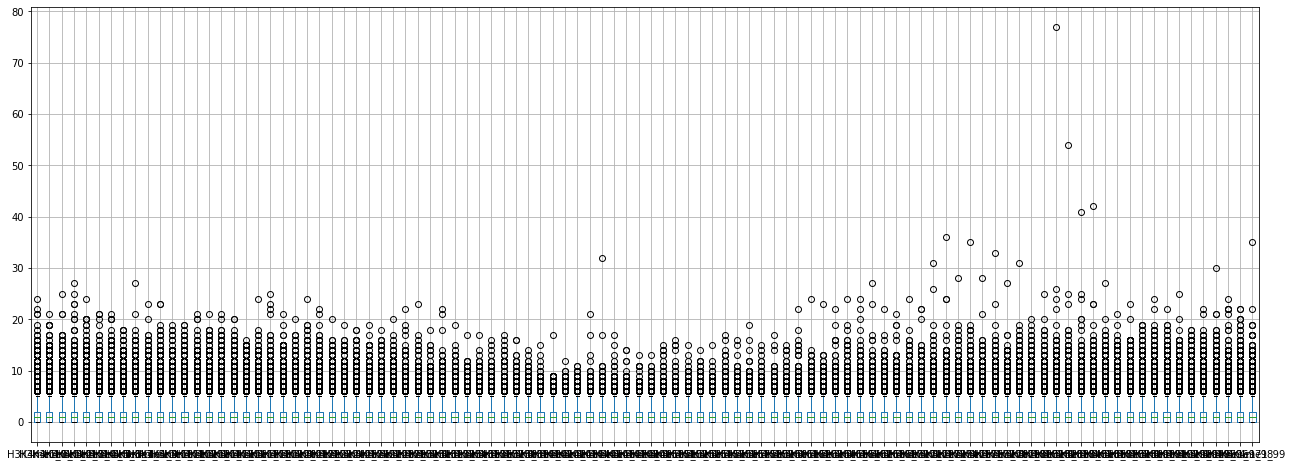

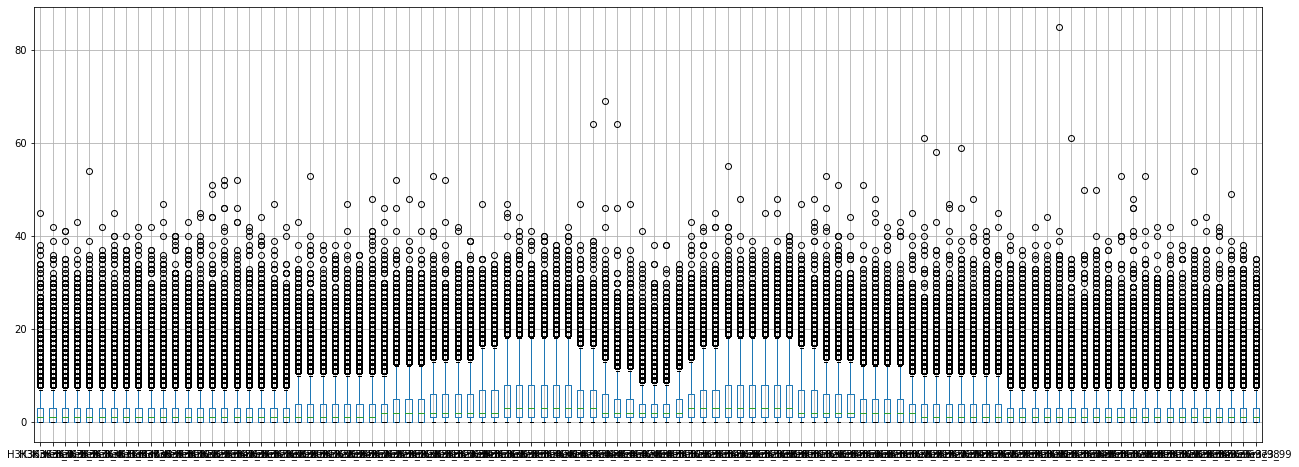

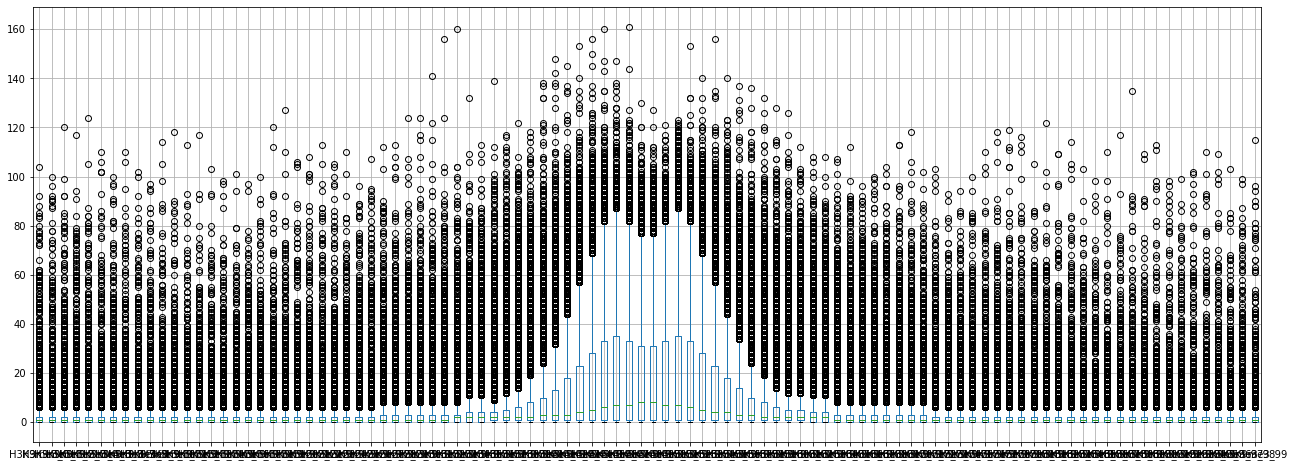

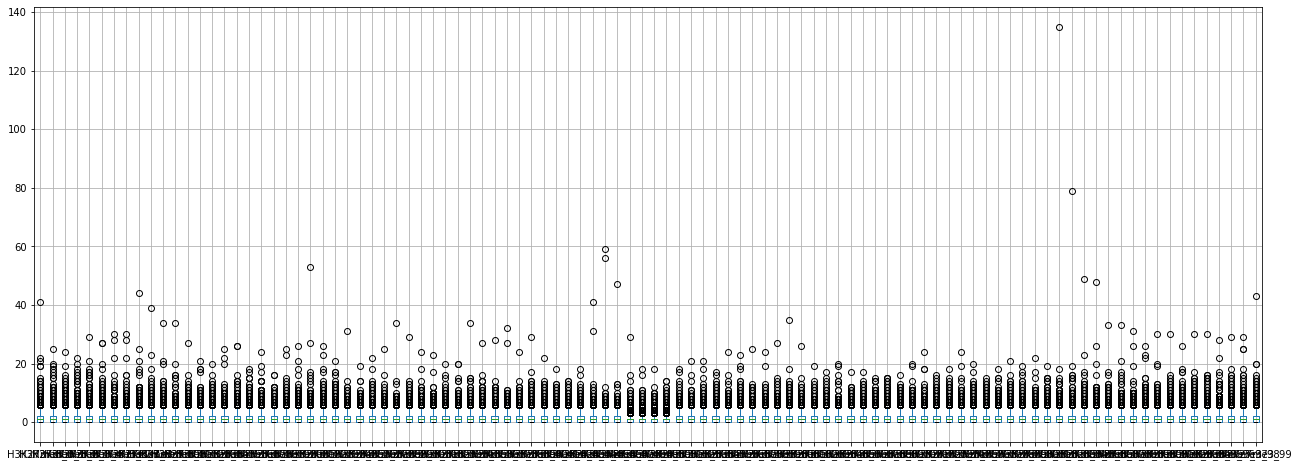

In [76]:
for mark in marks:
  cols = []
  for m in train.columns:
    if mark in m:
      cols.append(m)
  plt.figure(figsize=(22,8))    
  train[cols].boxplot()
  plt.show()

# 2. Our first model

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(train,train_labels,
                                                  test_size=.2, random_state=random_seed)

cls = LogisticRegression()

cls.fit(train_X,train_y)

predictions_train = cls.predict(train_X)
predictions_val = cls.predict(val_X)

print("Accuracy: (%f) %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

Accuracy: (0.867154) 0.838602


# 3. How well does it perform in pratice?

In [78]:
#code for submission
predictions_test = cls.predict(test)

to_write = pd.DataFrame()
to_write["GeneId"] = test_index_col
to_write["Label"] = predictions_test
to_write.to_csv("submission1.csv",index=False)

For the Kaggle competition your predictions are not evaluated by accuracy, but by log-loss:

$$ - \frac{1}{N} \sum_{i=1}^N [y_{i} \log \, p_{i} + (1 - y_{i}) \log \, (1 - p_{i})],$$

where $N$ is the number of datapoints, $y_i$ is the label of datapoint $i$, and $p_i$ is the prediction of the model expressed as a probability.

Let's compute the log-loss:

In [79]:
predictions_train_prob = cls.predict(train_X)
predictions_val_prob = cls.predict(val_X)

print("Log-loss: (%f) %f"%(log_loss(train_y,predictions_train_prob),log_loss(val_y,predictions_val_prob)))

Log-loss: (4.588397) 5.574569


# 4. Data pre-processing




Let's scale all the features to [0,1]:

In [80]:
from sklearn import preprocessing

scaler_minmax = preprocessing.MinMaxScaler()
scaler_minmax.fit(train)
train_norm = pd.DataFrame(scaler_minmax.transform(train),columns=train.columns)
train_norm.head()

,H3K4me3_0,H3K4me1_0,H3K36me3_0,H3K9me3_0,H3K27me3_0,H3K4me3_1,H3K4me1_1,H3K36me3_1,H3K9me3_1,H3K27me3_1,H3K4me3_2,H3K4me1_2,H3K36me3_2,H3K9me3_2,H3K27me3_2,H3K4me3_3,H3K4me1_3,H3K36me3_3,H3K9me3_3,H3K27me3_3,H3K4me3_4,H3K4me1_4,H3K36me3_4,H3K9me3_4,H3K27me3_4,H3K4me3_5,H3K4me1_5,H3K36me3_5,H3K9me3_5,H3K27me3_5,H3K4me3_6,H3K4me1_6,H3K36me3_6,H3K9me3_6,H3K27me3_6,H3K4me3_7,H3K4me1_7,H3K36me3_7,H3K9me3_7,H3K27me3_7,...,H3K4me3_92,H3K4me1_92,H3K36me3_92,H3K9me3_92,H3K27me3_92,H3K4me3_93,H3K4me1_93,H3K36me3_93,H3K9me3_93,H3K27me3_93,H3K4me3_94,H3K4me1_94,H3K36me3_94,H3K9me3_94,H3K27me3_94,H3K4me3_95,H3K4me1_95,H3K36me3_95,H3K9me3_95,H3K27me3_95,H3K4me3_96,H3K4me1_96,H3K36me3_96,H3K9me3_96,H3K27me3_96,H3K4me3_97,H3K4me1_97,H3K36me3_97,H3K9me3_97,H3K27me3_97,H3K4me3_98,H3K4me1_98,H3K36me3_98,H3K9me3_98,H3K27me3_98,H3K4me3_99,H3K4me1_99,H3K36me3_99,H3K9me3_99,H3K27me3_99
0,0.047619,0.041667,0.044444,0.009615,0.073171,0.023810,0.095238,0.119048,0.00,0.04,0.047619,0.12,0.195122,0.041667,0.125000,0.00,0.074074,0.186047,0.017094,0.272727,0.047619,0.000000,0.074074,0.024194,0.068966,0.000000,0.000000,0.047619,0.009091,0.000000,0.095238,0.047619,0.155556,0.05,0.000000,0.00,0.055556,0.15,0.009091,0.066667,...,0.045455,0.636364,0.714286,0.071429,0.133333,0.045455,0.64,0.552632,0.060606,0.038462,0.041667,0.666667,0.574074,0.039216,0.133333,0.000000,0.454545,0.704545,0.081818,0.033333,0.052632,0.566667,0.547619,0.027523,0.071429,0.086957,0.333333,0.326531,0.058252,0.103448,0.10,0.500000,0.394737,0.050505,0.068966,0.074074,0.285714,0.342857,0.017391,0.046512
1,0.000000,0.000000,0.022222,0.009615,0.000000,0.047619,0.000000,0.047619,0.00,0.08,0.095238,0.00,0.024390,0.000000,0.041667,0.05,0.000000,0.023256,0.000000,0.000000,0.047619,0.000000,0.018519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.00,0.000000,0.05,0.000000,0.00,0.000000,0.000000,...,0.136364,0.136364,0.000000,0.000000,0.000000,0.227273,0.08,0.026316,0.000000,0.000000,0.041667,0.055556,0.037037,0.019608,0.033333,0.090909,0.090909,0.022727,0.036364,0.033333,0.105263,0.033333,0.000000,0.018349,0.000000,0.000000,0.041667,0.020408,0.000000,0.000000,0.05,0.045455,0.000000,0.000000,0.000000,0.037037,0.028571,0.000000,0.000000,0.000000
2,0.333333,0.125000,0.022222,0.009615,0.024390,0.095238,0.095238,0.023810,0.01,0.08,0.095238,0.08,0.097561,0.008333,0.000000,0.05,0.037037,0.000000,0.000000,0.000000,0.190476,0.041667,0.000000,0.008065,0.034483,0.421053,0.095238,0.023810,0.018182,0.037037,0.190476,0.095238,0.044444,0.03,0.000000,0.05,0.111111,0.00,0.018182,0.000000,...,0.045455,0.000000,0.071429,0.000000,0.000000,0.090909,0.00,0.052632,0.010101,0.076923,0.125000,0.111111,0.055556,0.029412,0.066667,0.136364,0.045455,0.000000,0.009091,0.066667,0.105263,0.000000,0.000000,0.009174,0.107143,0.086957,0.000000,0.020408,0.009709,0.034483,0.05,0.045455,0.000000,0.020202,0.000000,0.037037,0.028571,0.028571,0.008696,0.000000
3,0.190476,0.083333,0.088889,0.009615,0.073171,0.000000,0.095238,0.023810,0.01,0.12,0.047619,0.24,0.024390,0.008333,0.041667,0.05,0.037037,0.000000,0.008547,0.045455,0.047619,0.041667,0.018519,0.000000,0.034483,0.105263,0.142857,0.023810,0.009091,0.000000,0.047619,0.047619,0.022222,0.02,0.066667,0.05,0.055556,0.05,0.009091,0.100000,...,0.045455,0.227273,0.000000,0.020408,0.000000,0.000000,0.12,0.078947,0.010101,0.038462,0.083333,0.111111,0.000000,0.000000,0.033333,0.227273,0.090909,0.045455,0.009091,0.066667,0.421053,0.033333,0.000000,0.009174,0.035714,0.086957,0.125000,0.020408,0.019417,0.068966,0.15,0.045455,0.052632,0.040404,0.068966,0.148148,0.085714,0.000000,0.000000,0.000000
4,0.047619,0.041667,0.044444,0.000000,0.195122,0.000000,0.095238,0.023810,0.01,0.12,0.000000,0.00,0.000000,0.016667,0.125000,0.05,0.111111,0.000000,0.008547,0.454545,0.047619,0.125000,0.000000,0.008065,0.275862,0.000000,0.000000,0.000000,0.027273,0.185185,0.000000,0.142857,0.044444,0.00,0.066667,0.05,0.000000,0.00,0.000000,0.100000,...,0.045455,0.045455,0.14285

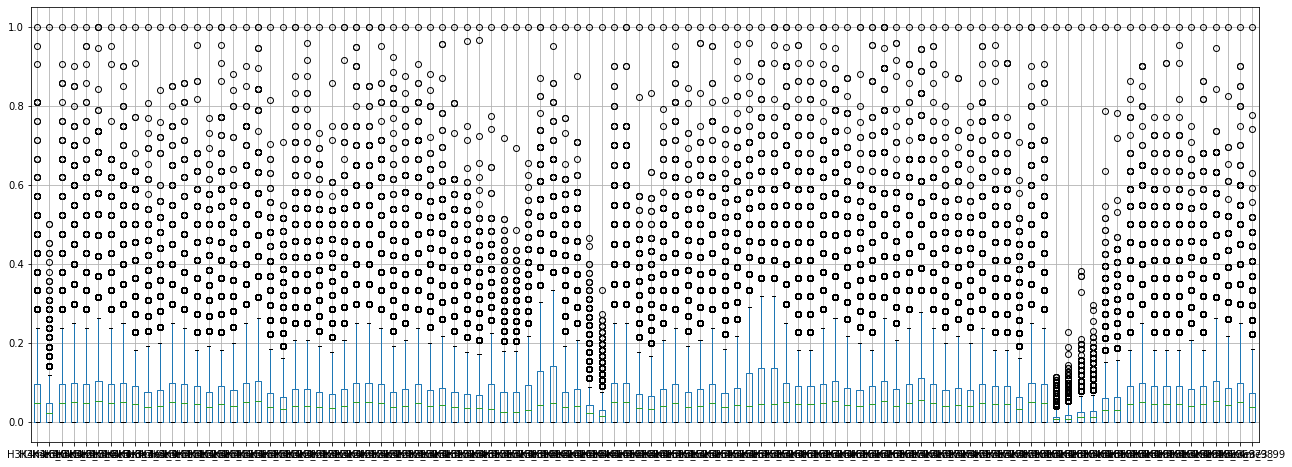

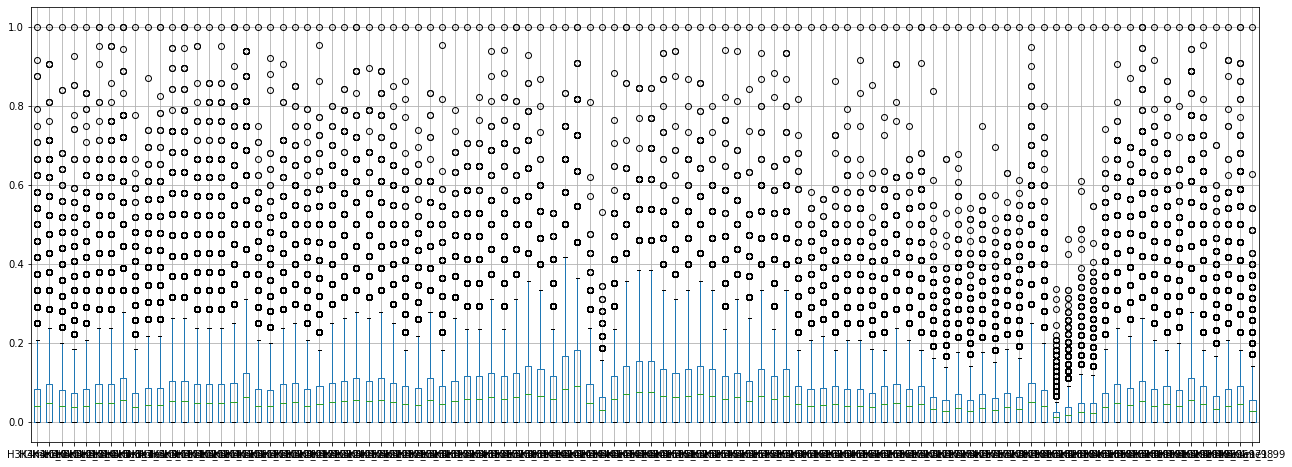

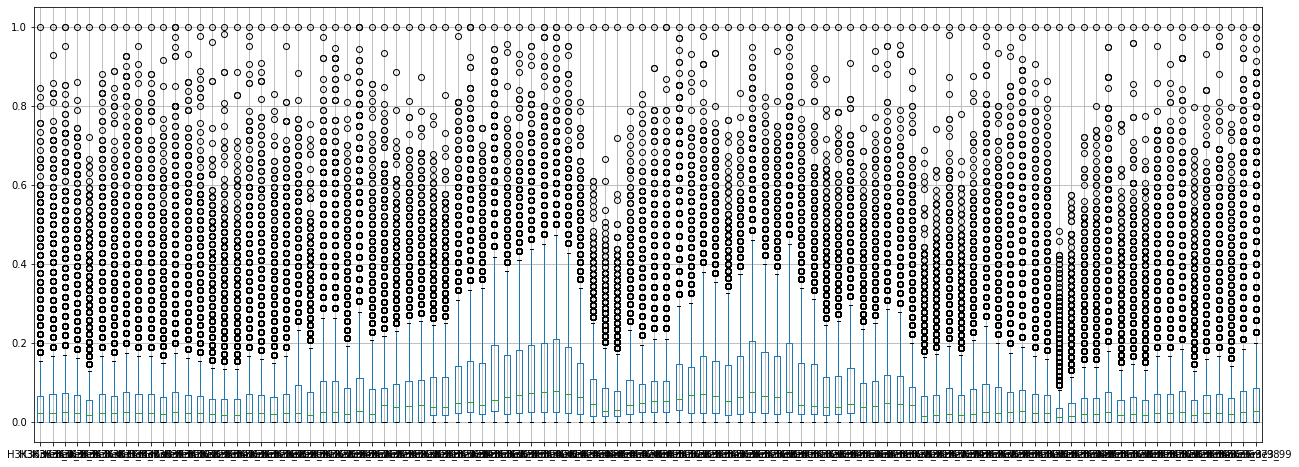

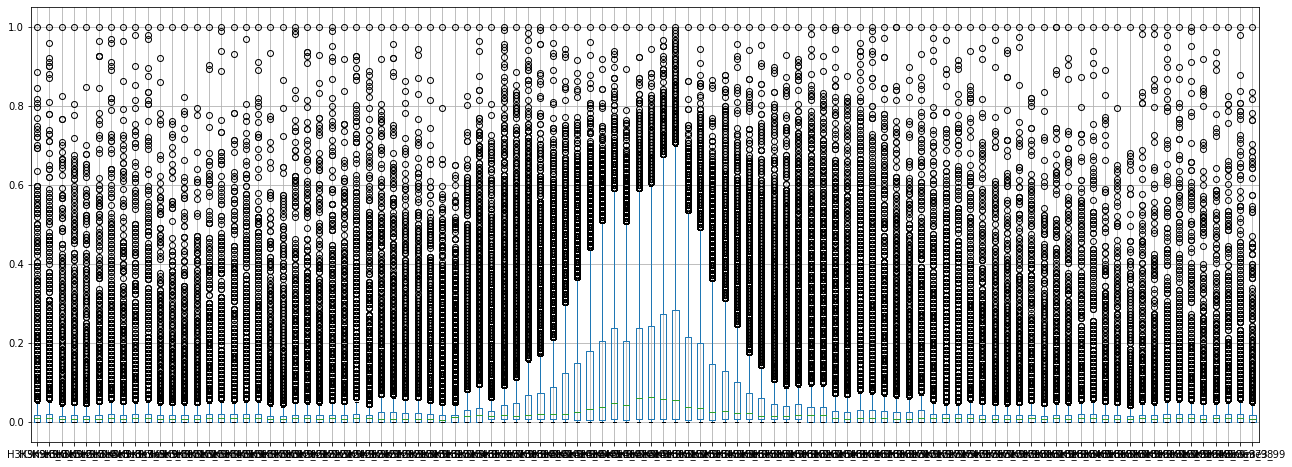

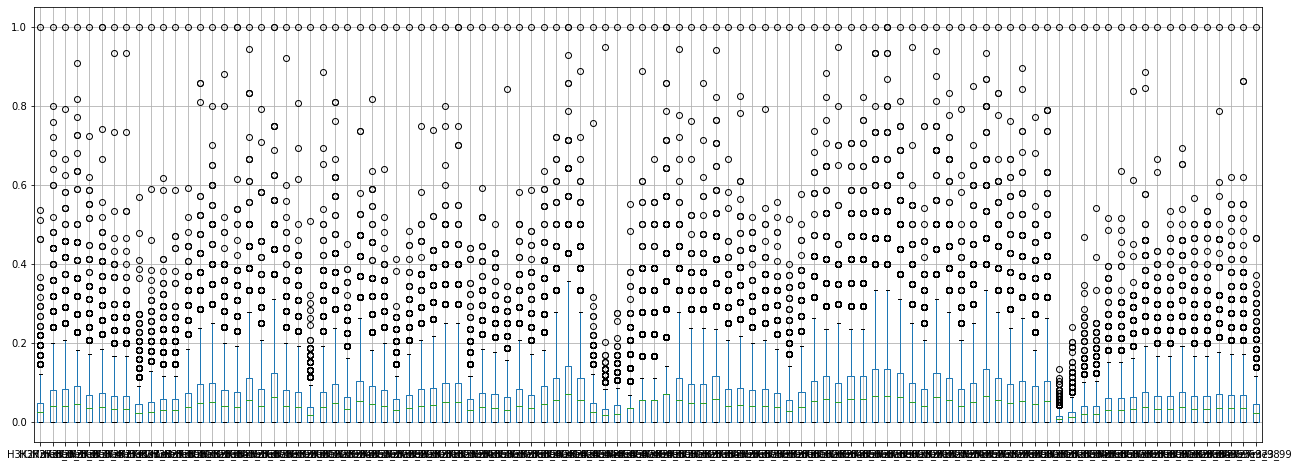

In [81]:
for mark in marks:
  cols = []
  for m in train_norm.columns:
    if mark in m:
      cols.append(m)
  plt.figure(figsize=(22,8))    
  train_norm[cols].boxplot()
  plt.show()

In [82]:
train_X, val_X, train_y, val_y = train_test_split(train_norm,train_labels,
                                                  test_size=.2, random_state=random_seed)

cls.fit(train_X,train_y)

predictions_train = cls.predict(train_X)
predictions_val = cls.predict(val_X)

print("Accuracy: (%f) %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

predictions_train_prob = cls.predict_proba(train_X)
predictions_val_prob = cls.predict_proba(val_X)

print("Log-loss: (%f) %f"%(log_loss(train_y,predictions_train_prob[:,1]),log_loss(val_y,predictions_val_prob[:,1])))

Accuracy: (0.863680) 0.854406
Log-loss: (0.348821) 0.375078


# 5. Hyperparameter tuning

In [94]:
from pycaret.classification import *

train_norm["Label"] = train_labels
setup(data=train_norm,target="Label",numeric_features=list(train.columns)[:-1], train_size=0.8, silent=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8525,0.9216,0.8669,0.8444,0.8555,0.7049,0.7052
1,0.8582,0.9241,0.8517,0.8649,0.8582,0.7165,0.7166
2,0.8544,0.9297,0.8182,0.8852,0.8504,0.7090,0.7111
3,0.8429,0.9000,0.8674,0.8297,0.8481,0.6856,0.6863
4,0.8582,0.9008,0.8409,0.8740,0.8571,0.7166,0.7171
5,0.8161,0.8819,0.8182,0.8182,0.8182,0.6321,0.6321
6,0.8487,0.8882,0.8447,0.8544,0.8495,0.6973,0.6974
7,0.8716,0.9296,0.8598,0.8833,0.8714,0.7433,0.7436
8,0.8311,0.8966,0.8213,0.8405,0.8308,0.6622,0.6624
9,0.8560,0.9191,0.8593,0.8561,0.8577,0.7121,0.7121


      H3K4me3_0  H3K4me1_0  H3K36me3_0  ...  H3K27me3_99  Label   Score
9224   0.000000   0.041667    0.000000  ...     0.000000      0  0.6806
6624   0.000000   0.083333    0.044444  ...     0.046512      0  0.5903
7349   0.000000   0.000000    0.000000  ...     0.093023      1  0.7969
1077   0.047619   0.000000    0.000000  ...     0.000000      0  0.9416
758    0.000000   0.000000    0.044444  ...     0.023256      0  0.8981
...         ...        ...         ...  ...          ...    ...     ...
8690   0.000000   0.000000    0.000000  ...     0.000000      1  0.7052
6826   0.285714   0.041667    0.000000  ...     0.023256      1  0.6776
5881   0.000000   0.125000    0.022222  ...     0.000000      0  0.5875
5703   0.333333   0.125000    0.000000  ...     0.046512      1  0.9109
7055   0.000000   0.083333    0.333333  ...     0.000000      1  0.9815

[2088 rows x 502 columns]


In [84]:
from sklearn.metrics import log_loss

def metric_clf_ks(y_true, y_pred, bins=10):
    print(y_pred)
    return 1

add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

Name                                                           LogLoss
Display Name                                                   LogLoss
Score Function                   <function log_loss at 0x7f53c1533268>
Scorer               make_scorer(log_loss, greater_is_better=False,...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: logloss, dtype: object

In [85]:
lr = create_model("lr")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.8515,0.9152,0.8349,0.8639,0.8491,0.7030,0.7034,0.3754
1,0.8431,0.8902,0.8445,0.8425,0.8435,0.6862,0.6862,0.4246
2,0.8695,0.9193,0.8612,0.8759,0.8685,0.7389,0.7390,0.3638
3,0.8275,0.8979,0.8206,0.8325,0.8265,0.6551,0.6552,0.4194
4,0.8563,0.9166,0.8708,0.8465,0.8585,0.7126,0.7129,0.3791
5,0.8467,0.9091,0.8182,0.8680,0.8424,0.6934,0.6946,0.3896
6,0.8491,0.9154,0.8397,0.8561,0.8478,0.6982,0.6983,0.3727
7,0.8575,0.9094,0.8493,0.8637,0.8565,0.7150,0.7151,0.3902
8,0.8597,0.9164,0.8537,0.8641,0.8589,0.7194,0.7195,0.3726
9,0.8477,0.9171,0.8541,0.8440,0.8490,0.6954,0.6955,0.3727


In [87]:
tuned_lr = tune_model(lr,tuner_verbose=2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.8527,0.9168,0.8349,0.8660,0.8502,0.7054,0.7059,0.3712
1,0.8443,0.8920,0.8469,0.8429,0.8449,0.6886,0.6886,0.4190
2,0.8707,0.9222,0.8636,0.8762,0.8699,0.7413,0.7414,0.3583
3,0.8347,0.8991,0.8278,0.8398,0.8337,0.6695,0.6695,0.4149
4,0.8551,0.9177,0.8732,0.8430,0.8578,0.7102,0.7106,0.3757
5,0.8503,0.9099,0.8206,0.8728,0.8459,0.7006,0.7019,0.3858
6,0.8503,0.9166,0.8421,0.8564,0.8492,0.7006,0.7007,0.3709
7,0.8599,0.9106,0.8517,0.8662,0.8589,0.7198,0.7199,0.3870
8,0.8645,0.9178,0.8561,0.8707,0.8634,0.7290,0.7291,0.3691
9,0.8477,0.9190,0.8541,0.8440,0.8490,0.6954,0.6955,0.3682


In [88]:
evaluate_model(tuned_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [95]:
final_lr = finalize_model(lr)



      H3K4me3_0  H3K4me1_0  H3K36me3_0  ...  H3K27me3_99  Label   Score
9224   0.000000   0.041667    0.000000  ...     0.000000      0  0.6806
6624   0.000000   0.083333    0.044444  ...     0.046512      0  0.5903
7349   0.000000   0.000000    0.000000  ...     0.093023      1  0.7969
1077   0.047619   0.000000    0.000000  ...     0.000000      0  0.9416
758    0.000000   0.000000    0.044444  ...     0.023256      0  0.8981
...         ...        ...         ...  ...          ...    ...     ...
8690   0.000000   0.000000    0.000000  ...     0.000000      1  0.7052
6826   0.285714   0.041667    0.000000  ...     0.023256      1  0.6776
5881   0.000000   0.125000    0.022222  ...     0.000000      0  0.5875
5703   0.333333   0.125000    0.000000  ...     0.046512      1  0.9109
7055   0.000000   0.083333    0.333333  ...     0.000000      1  0.9815

[2088 rows x 502 columns]


In [100]:
result = predict_model(lr,data=test)
print(result)

      H3K4me3_0  H3K4me1_0  H3K36me3_0  ...  H3K27me3_99  Label   Score
0             2          2           7  ...            1      1  1.0000
1             1          2           0  ...            1      1  1.0000
2             1          1           2  ...            0      1  0.9995
3             1          5           2  ...            0      1  1.0000
4             1         16           3  ...            1      1  1.0000
...         ...        ...         ...  ...          ...    ...     ...
5044          0          0           0  ...            2      1  1.0000
5045          1          3           3  ...            0      1  1.0000
5046          0          5           2  ...            0      1  1.0000
5047          7          1           0  ...            1      0  1.0000
5048          3          2           0  ...            3      1  1.0000

[5049 rows x 502 columns]


In [103]:
to_write = pd.DataFrame()
to_write["GeneId"] = test_index_col
to_write["Label"] = result["Score"]
to_write.to_csv("submission2.csv",index=False)

In [104]:
to_write

,GeneId,Label
0,5222,1.0000
1,891,1.0000
2,7219,0.9995
3,7225,1.0000
4,9432,1.0000
...,...,...
5044,7987,1.0000
5045,5046,1.0000
5046,13738,1.0000
5047,9341,1.0000
